In [1]:
## This notebook will contain linear regression for
    # 1. Sunspot
    # 2. Mackey-Glass
    # 3. Lorenz

In [2]:
# import libraries 
import pandas as pd                                          # for reading dataset
import numpy as np
from reservoirpy.datasets import mackey_glass 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split         # for shuffling & splitting data

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression            # for model fitting
from sklearn.metrics import mean_squared_error               # for model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error   # https://scales.arabpsychology.com/stats/interpret-mape-values/

import matplotlib.pyplot as plt                              # for results visualisation

In [3]:
## Define function
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# tilted loss function - crux of quantile regression
def tilted_loss(beta, X, y, tau):
    y_pred = np.dot(X, beta.reshape(X.shape[1], -1)) # multi step ahead version
    u = y - y_pred
    loss = np.where(u >= 0, tau * u, (tau - 1) * u)
    return np.sum(loss)

In [4]:
## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [5]:
# 1. Sunspot (Classic Linear regression)
Sunspot = pd.read_csv('data/Sunspots.csv')
response = Sunspot['Monthly Mean Total Sunspot Number']
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(response).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [6]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Linear Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

Exp 1 on test set: RMSE: 0.0803, MAE: 22.36, MAPE: 1217712084068963.0000
Exp 2 on test set: RMSE: 0.0776, MAE: 22.53, MAPE: 966278764455048.6250
Exp 3 on test set: RMSE: 0.0761, MAE: 21.89, MAPE: 1279171795257160.2500
Exp 4 on test set: RMSE: 0.0805, MAE: 23.09, MAPE: 1017365087893911.5000
Exp 5 on test set: RMSE: 0.0793, MAE: 22.92, MAPE: 1089335787658290.8750
Exp 6 on test set: RMSE: 0.0796, MAE: 22.94, MAPE: 1106483343998635.8750
Exp 7 on test set: RMSE: 0.0776, MAE: 22.13, MAPE: 1410693647985819.7500
Exp 8 on test set: RMSE: 0.0812, MAE: 23.25, MAPE: 724404252908426.5000
Exp 9 on test set: RMSE: 0.0800, MAE: 23.19, MAPE: 1297758884738800.5000
Exp 10 on test set: RMSE: 0.0777, MAE: 22.36, MAPE: 970803749744046.6250
Exp 11 on test set: RMSE: 0.0798, MAE: 22.60, MAPE: 1192722087229397.7500
Exp 12 on test set: RMSE: 0.0797, MAE: 22.68, MAPE: 1454482406518150.0000
Exp 13 on test set: RMSE: 0.0789, MAE: 22.59, MAPE: 1713170017136190.7500
Exp 14 on test set: RMSE: 0.0819, MAE: 23.21, MAPE

In [7]:
# MAPE not very suitable here: no need to report MAPE (not a useful model eval metric for this scenario)
# percentage difference across 6 steps stacks up quickly and the nature of the sunspots data are not suitable
    # e.g. actual = 0.1, pred = 10

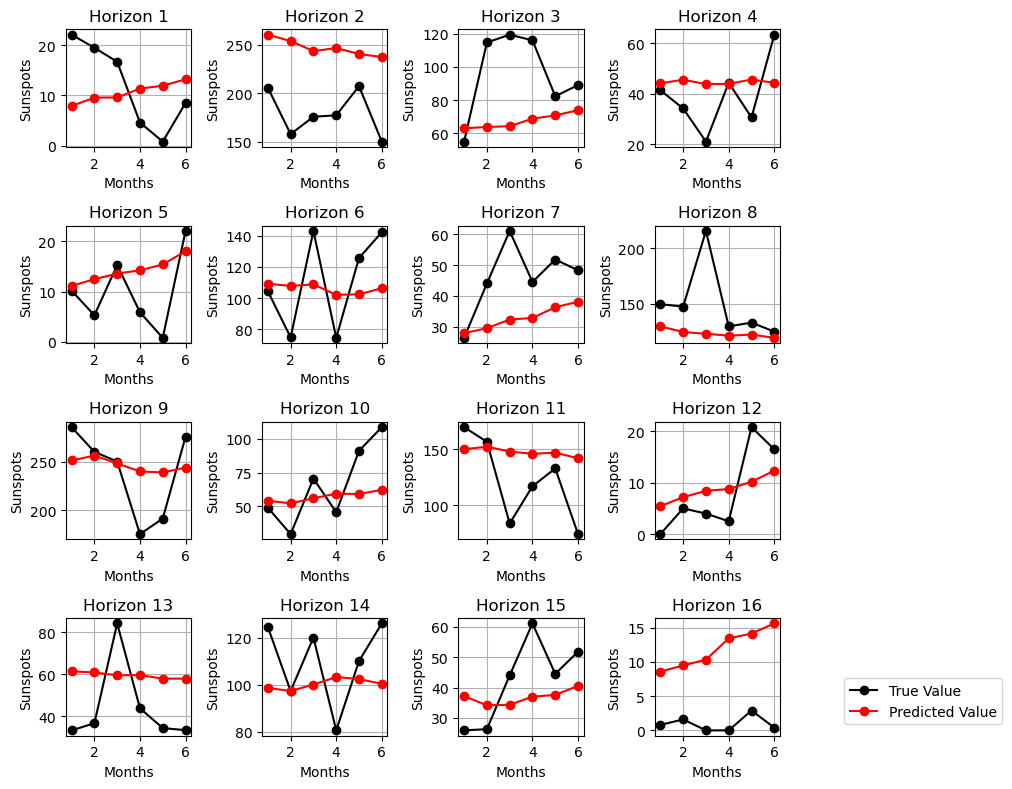

In [8]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspots')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [9]:
# Linear Regression Quantile ver

# Usage
input_size = 10        # 5 steps input
output_size = 6        # 3 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 5    # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [10]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0820, MAE: 22.46, MAPE: 538809969166112.9375
Exp 2 on test set: RMSE: 0.0787, MAE: 22.45, MAPE: 492475744356864.4375
Exp 3 on test set: RMSE: 0.0767, MAE: 21.47, MAPE: 699987950655861.8750
Exp 4 on test set: RMSE: 0.0810, MAE: 22.77, MAPE: 485574756018245.5000
Exp 5 on test set: RMSE: 0.0800, MAE: 22.60, MAPE: 389149118283966.5000
--------------------------------------------
Univariate Quantile Regression Avg RMSE: 0.0797, Avg MAE: 22.35, Avg MAPE: 52119950769621016.000%
At time step 1, Avg RMSE: 0.0562, Avg MAE: 17.88, Avg MAPE: 36891308560026072.000%
At time step 2, Avg RMSE: 0.0797, Avg MAE: 20.43, Avg MAPE: 48536970206729016.000%
At time step 3, Avg RMSE: 0.0717, Avg MAE: 21.66, Avg MAPE: 48898374922761728.000%
At time step 4, Avg RMSE: 0.0309, Avg MAE: 23.29, Avg MAPE: 41464591312445760.000%
At time step 5, Avg RMSE: 0.0663, Avg MAE: 24.99, Avg MAPE: 59301690487956264.000%
At time step 6, Avg RMSE: 0.0498, Avg MAE: 25.86, Avg MAPE: 77626769127807552.000%

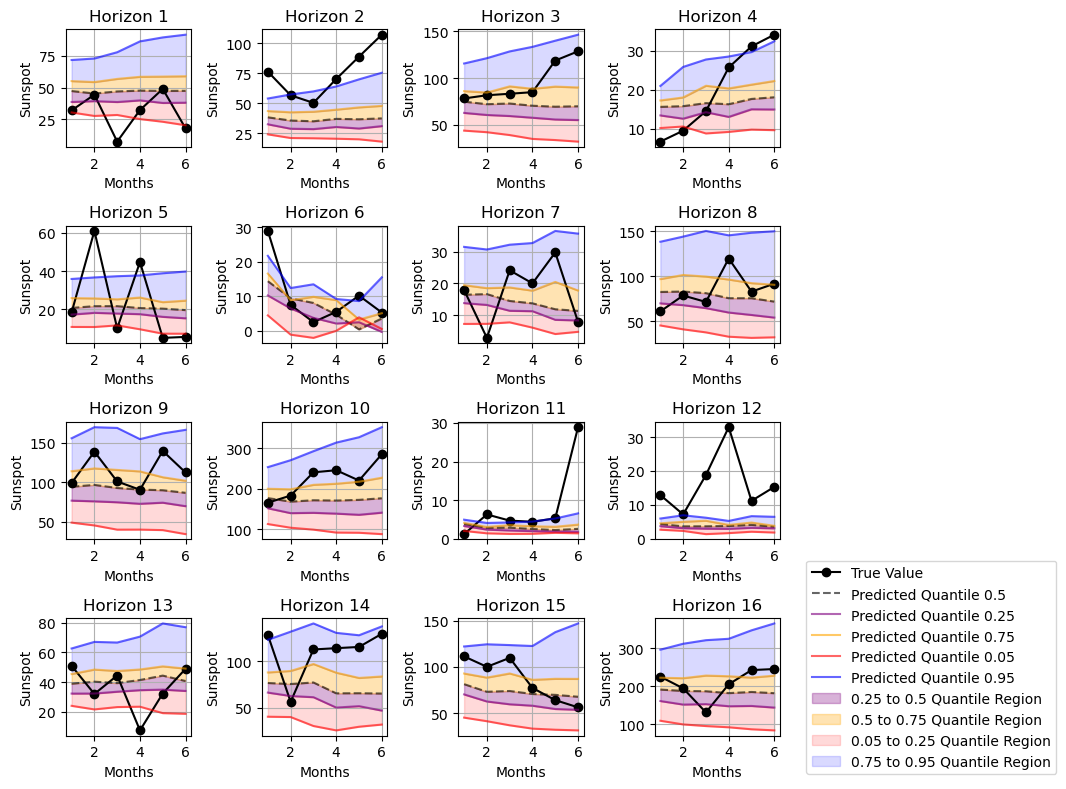

In [11]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Months')
    ax.set_ylabel('Sunspot')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [12]:
# It seems that quantile regression have trouble handling values near 0
# Will be interesting to see its performance with chaotic time series...

In [13]:
# 2. Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data))    # Set the index to be a range of integers

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [15]:
## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [16]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Linear Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(rmse_steps[step]):.4f}, Avg MAE: {np.mean(mae_steps[step]):.2f}, Avg MAPE: {np.mean(mape_steps[step])*100:.3f}%")

Exp 1 on test set: RMSE: 0.0401, MAE: 0.02, MAPE: 0.0207
Exp 2 on test set: RMSE: 0.0330, MAE: 0.02, MAPE: 0.0206
Exp 3 on test set: RMSE: 0.0360, MAE: 0.02, MAPE: 0.0214
Exp 4 on test set: RMSE: 0.0326, MAE: 0.02, MAPE: 0.0211
Exp 5 on test set: RMSE: 0.0351, MAE: 0.02, MAPE: 0.0206
Exp 6 on test set: RMSE: 0.0356, MAE: 0.02, MAPE: 0.0215
Exp 7 on test set: RMSE: 0.0291, MAE: 0.02, MAPE: 0.0195
Exp 8 on test set: RMSE: 0.0509, MAE: 0.02, MAPE: 0.0214
Exp 9 on test set: RMSE: 0.0343, MAE: 0.02, MAPE: 0.0225
Exp 10 on test set: RMSE: 0.0377, MAE: 0.02, MAPE: 0.0211
Exp 11 on test set: RMSE: 0.0326, MAE: 0.02, MAPE: 0.0218
Exp 12 on test set: RMSE: 0.0296, MAE: 0.02, MAPE: 0.0198
Exp 13 on test set: RMSE: 0.0407, MAE: 0.02, MAPE: 0.0220
Exp 14 on test set: RMSE: 0.0361, MAE: 0.02, MAPE: 0.0211
Exp 15 on test set: RMSE: 0.0614, MAE: 0.02, MAPE: 0.0228
Exp 16 on test set: RMSE: 0.0304, MAE: 0.02, MAPE: 0.0195
Exp 17 on test set: RMSE: 0.0305, MAE: 0.02, MAPE: 0.0205
Exp 18 on test set: RMS

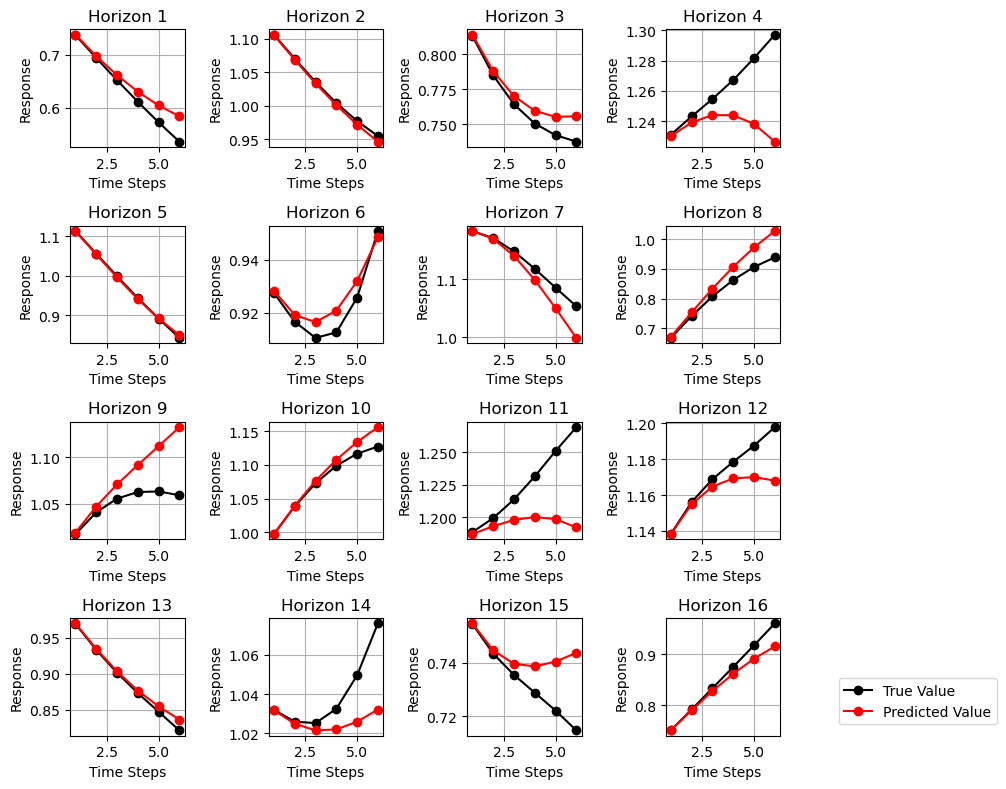

In [17]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [18]:
# Amazing! :D
# Interestingly, prediction works better for chaotic time series

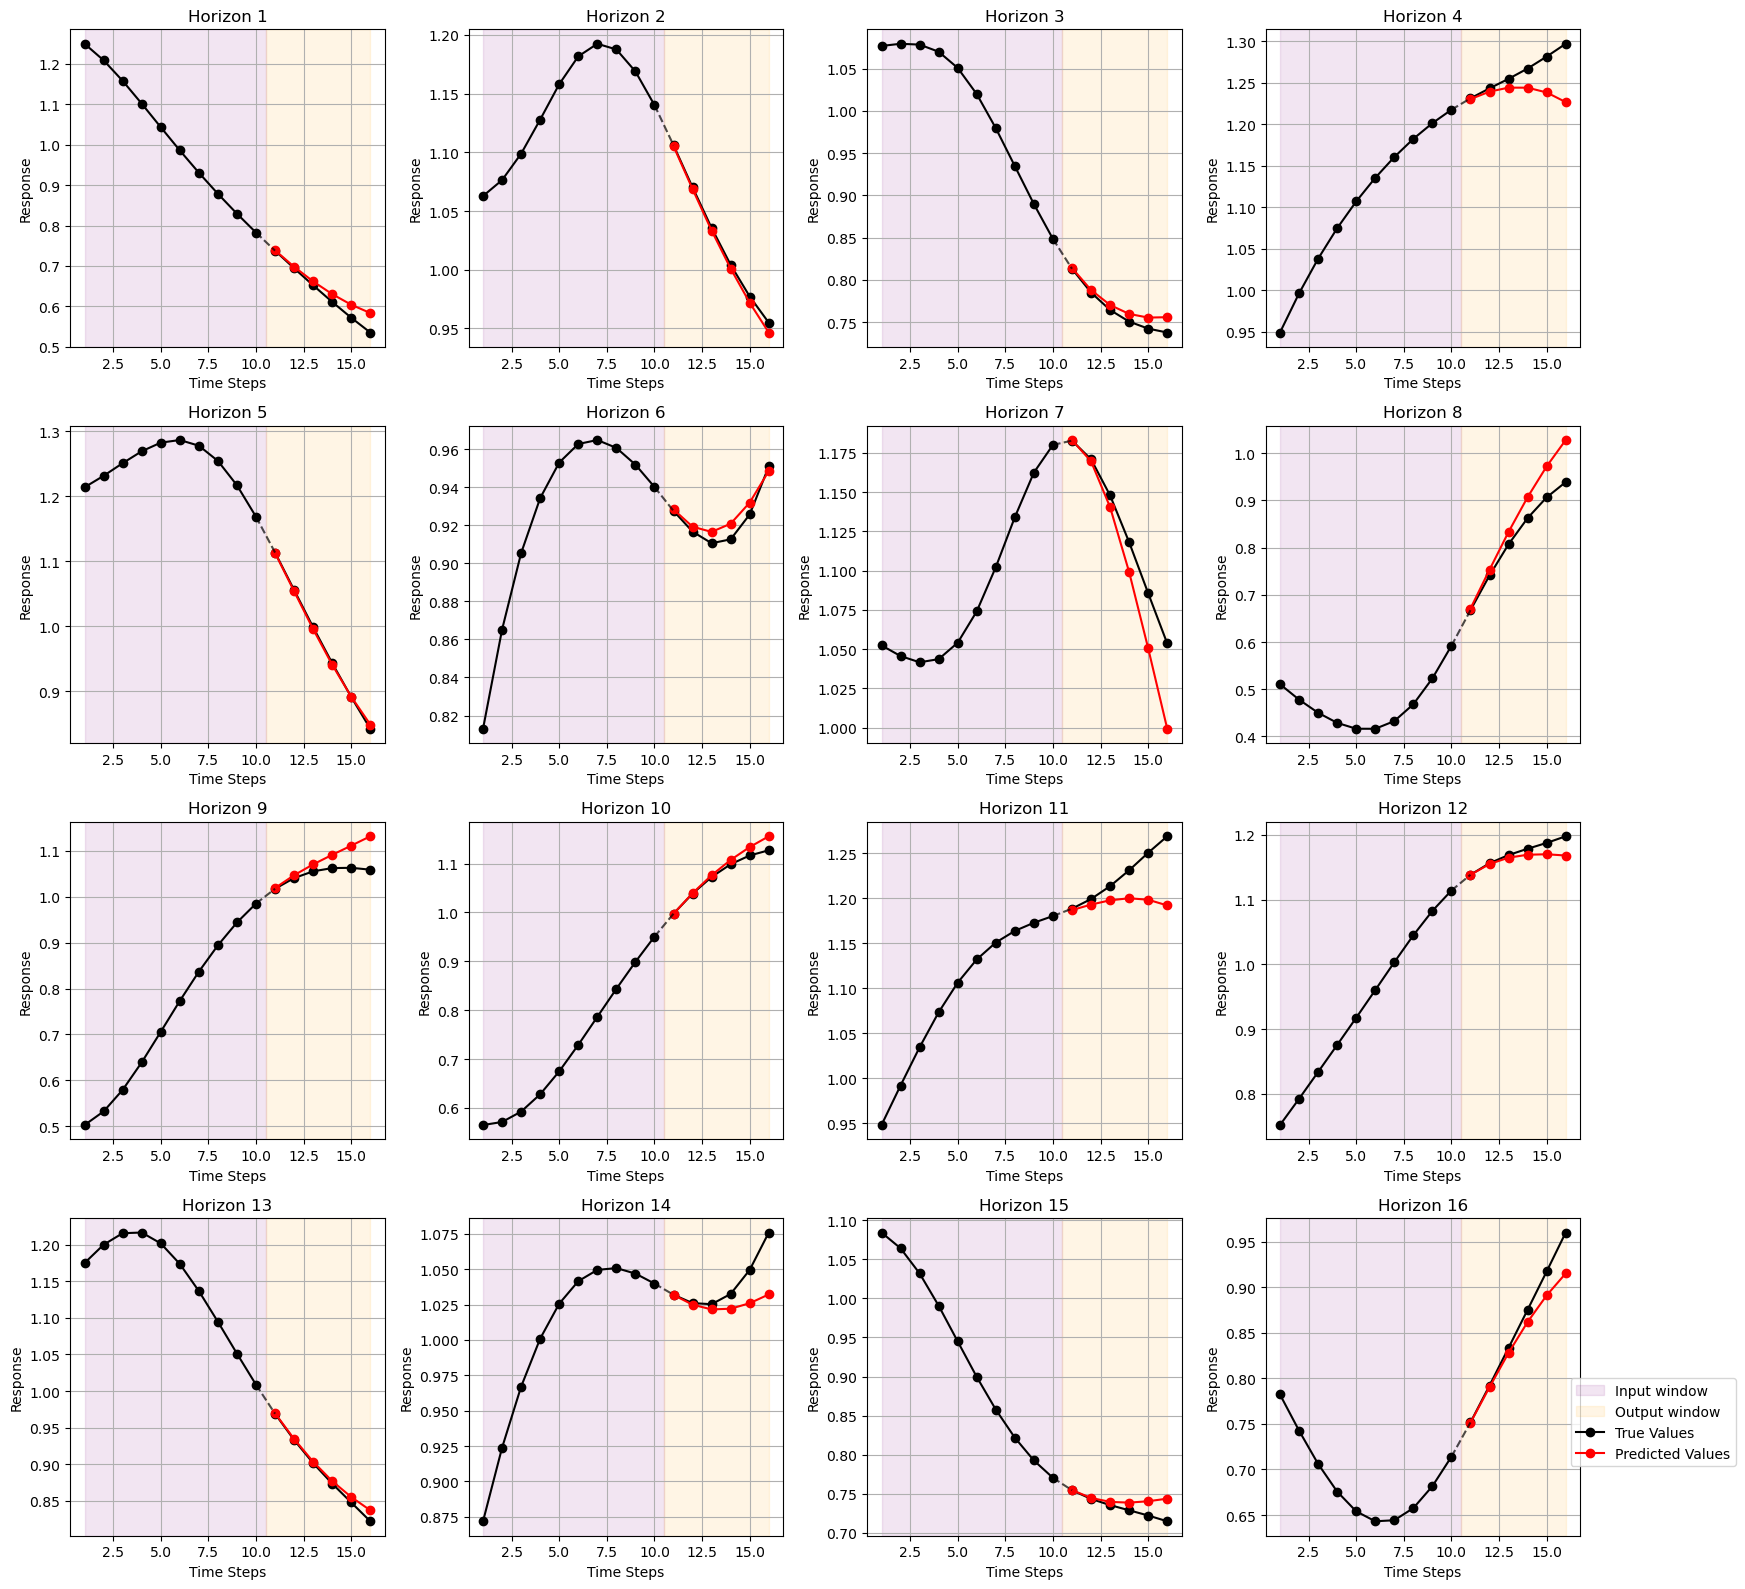

In [19]:
X_test_inv = scaler.inverse_transform(X_test)
y_test_inv = scaler.inverse_transform(y_test)

# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()
for i in range(16):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], y_test_inv[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], y_test_inv[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [20]:
## Quantile Ver: Linear Regression Mackey-Glass
data = mackey_glass(n_timesteps = 3000, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
data = data.flatten()
data = pd.Series(data, name='Response')
data.index = range(len(data))

scaler = MinMaxScaler(feature_range=(0, 1))
response_reshaped = np.array(data).reshape(-1, 1)
response_scaled = scaler.fit_transform(response_reshaped).flatten()

In [21]:
# Usage
input_size = 10        # 10 steps input
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 5    # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [22]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(response_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0760, MAE: 0.02, MAPE: 0.0226
Exp 2 on test set: RMSE: 0.0953, MAE: 0.02, MAPE: 0.0220
Exp 3 on test set: RMSE: 0.0901, MAE: 0.02, MAPE: 0.0226
Exp 4 on test set: RMSE: 0.0512, MAE: 0.02, MAPE: 0.0199
Exp 5 on test set: RMSE: 0.0960, MAE: 0.02, MAPE: 0.0249
--------------------------------------------
Univariate Quantile Regression Avg RMSE: 0.0817, Avg MAE: 0.02, Avg MAPE: 2.239%
At time step 1, Avg RMSE: 0.0158, Avg MAE: 0.00, Avg MAPE: 0.116%
At time step 2, Avg RMSE: 0.0268, Avg MAE: 0.00, Avg MAPE: 0.477%
At time step 3, Avg RMSE: 0.0177, Avg MAE: 0.01, Avg MAPE: 1.240%
At time step 4, Avg RMSE: 0.0195, Avg MAE: 0.02, Avg MAPE: 2.314%
At time step 5, Avg RMSE: 0.0085, Avg MAE: 0.03, Avg MAPE: 3.754%
At time step 6, Avg RMSE: 0.1487, Avg MAE: 0.05, Avg MAPE: 5.529%
--------------------------------------------
At Quantile 0.05, it has Avg RMSE: 0.0635
At Quantile 0.25, it has Avg RMSE: 0.0747
At Quantile 0.5, it has Avg RMSE: 0.0817
At Quantile 0.75, it ha

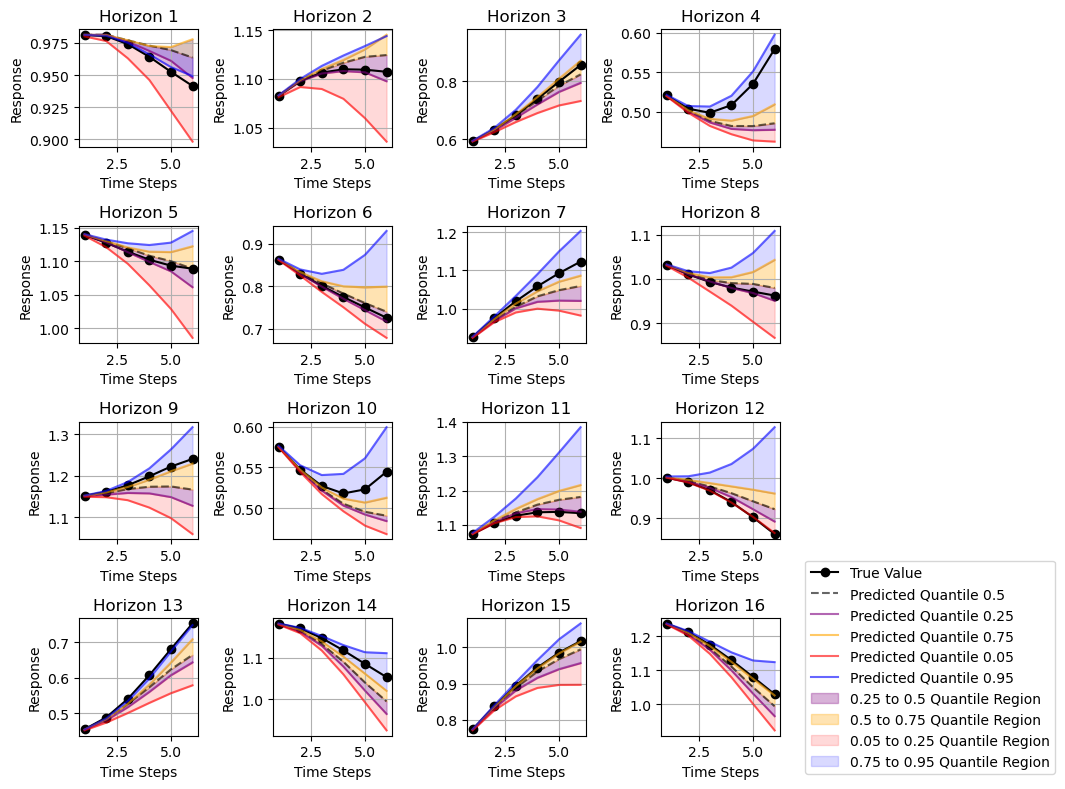

In [23]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [24]:
# It's Beautiful... :')

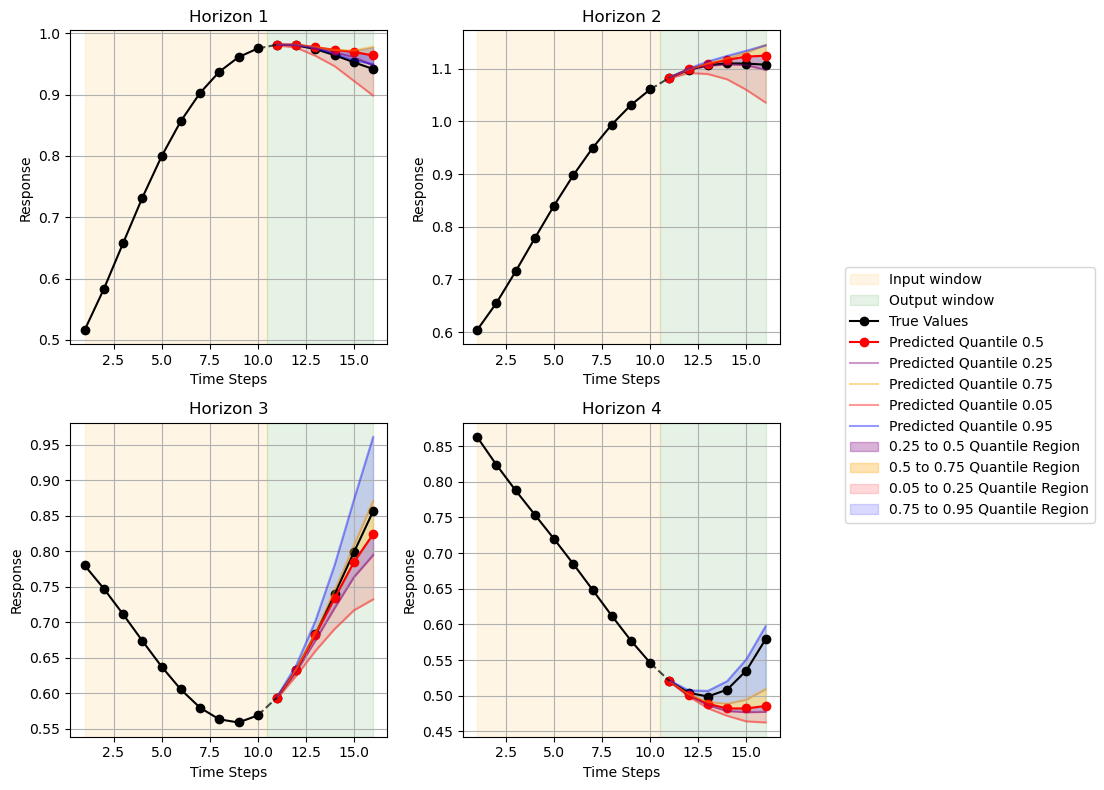

In [25]:
X_test_inv = scaler.inverse_transform(X_test)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(4):
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='orange', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='green', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], actual_values[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.5])[i], marker='o', linestyle='-', color='red', label='Predicted Quantile 0.5')
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.4)
    ax.plot(full_time_steps[input_size:], scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.4)
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], actual_values[i][0]], linestyle='--', color='black', alpha=0.7)

    # Highlight regions between quantiles
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(full_time_steps[input_size:], scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Response')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [26]:
# 3. Lorenz
# https://en.wikipedia.org/wiki/Lorenz_system
def lorenz(xyz, *, s=10, r=28, b=2.667):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

In [27]:
dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

In [28]:
# break it down to 3 univariate time series
x_dimension = xyzs[:, 0]
y_dimension = xyzs[:, 1]
z_dimension = xyzs[:, 2]

In [29]:
x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
y_dimension = y_dimension.flatten()
y_dimension = pd.Series(y_dimension, name='Value')
z_dimension = z_dimension.flatten()
z_dimension = pd.Series(z_dimension, name='Value')

x_dimension.index = range(len(x_dimension))
y_dimension.index = range(len(y_dimension))
z_dimension.index = range(len(z_dimension))
# print(x_dimension), print(y_dimension), print(z_dimension)

In [30]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
y_reshaped = np.array(y_dimension).reshape(-1, 1)
z_reshaped = np.array(z_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()
y_scaled = scaler.fit_transform(y_reshaped).flatten()
z_scaled = scaler.fit_transform(z_reshaped).flatten()

In [31]:
## Usage: define our parameters
input_size = 10        # 10 steps input (showcase our model can handle different input/output sizes)
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

x_rmse, x_mae, x_mape = [], [], []
y_rmse, y_mae, y_mape = [], [], []
z_rmse, z_mae, z_mape = [], [], []

metrics = ['rmse', 'mae', 'mape']
variables = ['x', 'y', 'z']
metric_dict = {f"{var}_{metric}_steps": [[] for _ in range(output_size)] for var in variables for metric in metrics}

In [32]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    x_mse = mean_squared_error(y_test, y_pred)
    x_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        x_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['x_rmse_steps'][step].append(np.sqrt(x_mse_step))

    # Inverse Transform
    x_predicted_values = scaler.inverse_transform(y_pred)
    x_actual_values = scaler.inverse_transform(y_test)

    x_mae.append(mean_absolute_error(x_actual_values, x_predicted_values))
    x_mape.append(mean_absolute_percentage_error(x_actual_values, x_predicted_values))

    actual_values_steps = list(zip(*x_actual_values))
    predicted_values_steps = list(zip(*x_predicted_values))

    for step in range(output_size):
        metric_dict['x_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['x_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    ####

    X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_mse = mean_squared_error(y_test, y_pred)
    y_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        y_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['y_rmse_steps'][step].append(np.sqrt(y_mse_step))


    # Inverse Transform
    y_predicted_values = scaler.inverse_transform(y_pred)
    y_actual_values = scaler.inverse_transform(y_test)
    
    y_mae.append(mean_absolute_error(y_actual_values, y_predicted_values))
    y_mape.append(mean_absolute_percentage_error(y_actual_values, y_predicted_values))

    actual_values_steps = list(zip(*y_actual_values))
    predicted_values_steps = list(zip(*y_predicted_values))

    for step in range(output_size):
        metric_dict['y_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['y_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    ####

    X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    z_mse = mean_squared_error(y_test, y_pred)
    z_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        z_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['z_rmse_steps'][step].append(np.sqrt(z_mse_step))

    # Inverse Transform
    z_predicted_values = scaler.inverse_transform(y_pred)
    z_actual_values = scaler.inverse_transform(y_test)
    
    z_mae.append(mean_absolute_error(z_actual_values, z_predicted_values))
    z_mape.append(mean_absolute_percentage_error(z_actual_values, z_predicted_values))

    actual_values_steps = list(zip(*z_actual_values))
    predicted_values_steps = list(zip(*z_predicted_values))

    for step in range(output_size):
        metric_dict['z_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['z_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    
    # print(f"Exp {i+1} on x test set: RMSE: {x_rmse[i]:.7f}, MAE: {x_mae[i]:.5f}, MAPE: {x_mape[i]:.7f}")
    seed += 1

print(f"Univariate Linear Regression x dimension: Avg RMSE: {np.mean(x_rmse):.6f}, Avg MAE: {np.mean(x_mae):.4f}, Avg MAPE: {np.mean(x_mape)*100:.4f}%")
print(f"Univariate Linear Regression y dimension: Avg RMSE: {np.mean(y_rmse):.6f}, Avg MAE: {np.mean(y_mae):.4f}, Avg MAPE: {np.mean(y_mape)*100:.4f}%")
print(f"Univariate Linear Regression z dimension: Avg RMSE: {np.mean(z_rmse):.6f}, Avg MAE: {np.mean(z_mae):.4f}, Avg MAPE: {np.mean(z_mape)*100:.4f}%")

for step in range(output_size):
    print(f"At time step {step + 1}: ")
    print(f"     X Dimension - Avg RMSE: {np.mean(metric_dict['x_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['x_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['x_mape_steps'][step])*100:.3f}%")
    print(f"     Y Dimension - Avg RMSE: {np.mean(metric_dict['y_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['y_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['y_mape_steps'][step])*100:.3f}%")
    print(f"     Z Dimension - Avg RMSE: {np.mean(metric_dict['z_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['z_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['z_mape_steps'][step])*100:.3f}%")


Univariate Linear Regression x dimension: Avg RMSE: 0.095963, Avg MAE: 0.0015, Avg MAPE: 0.0095%
Univariate Linear Regression y dimension: Avg RMSE: 0.095963, Avg MAE: 0.0057, Avg MAPE: 0.0361%
Univariate Linear Regression z dimension: Avg RMSE: 0.095963, Avg MAE: 0.0056, Avg MAPE: 0.0289%
At time step 1: 
     X Dimension - Avg RMSE: 0.0001, Avg MAE: 0.0000, Avg MAPE: 0.000%
     Y Dimension - Avg RMSE: 0.0004, Avg MAE: 0.0000, Avg MAPE: 0.000%
     Z Dimension - Avg RMSE: 0.0003, Avg MAE: 0.0000, Avg MAPE: 0.000%
At time step 2: 
     X Dimension - Avg RMSE: 0.0001, Avg MAE: 0.0000, Avg MAPE: 0.000%
     Y Dimension - Avg RMSE: 0.0002, Avg MAE: 0.0002, Avg MAPE: 0.001%
     Z Dimension - Avg RMSE: 0.0002, Avg MAE: 0.0002, Avg MAPE: 0.001%
At time step 3: 
     X Dimension - Avg RMSE: 0.0000, Avg MAE: 0.0002, Avg MAPE: 0.001%
     Y Dimension - Avg RMSE: 0.0002, Avg MAE: 0.0009, Avg MAPE: 0.005%
     Z Dimension - Avg RMSE: 0.0002, Avg MAE: 0.0008, Avg MAPE: 0.004%
At time step 4: 
  

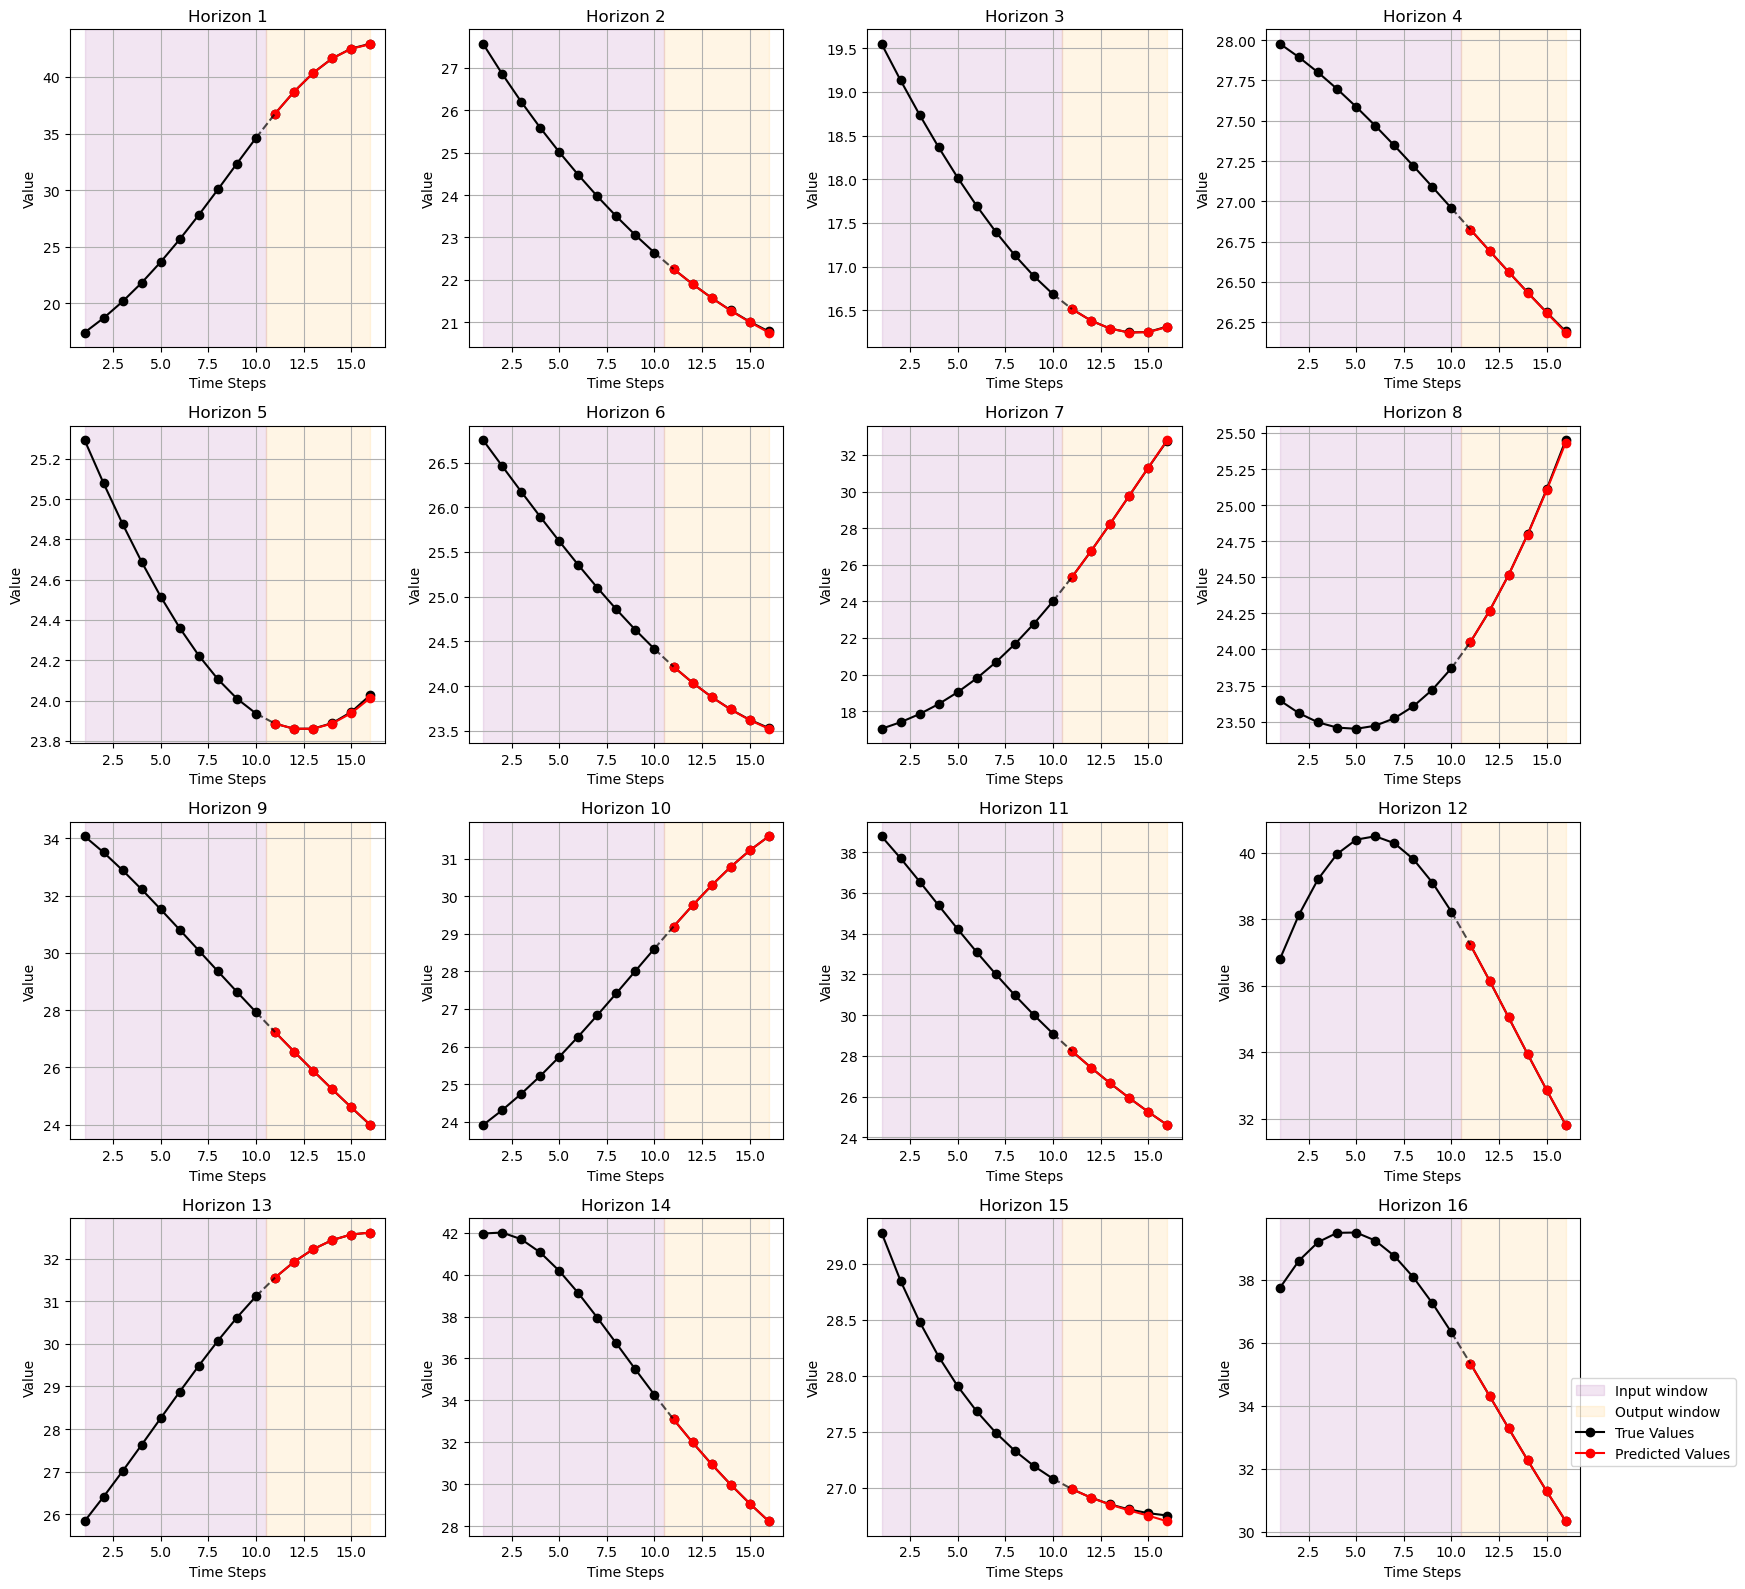

In [33]:
X_test_inv = scaler.inverse_transform(X_test)
# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.flatten()
for i in range(16):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], marker='o', linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], z_actual_values[i], marker='o', linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], z_predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], z_actual_values[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [34]:
## Above are some example results for Z dimension - result is extremely accurate

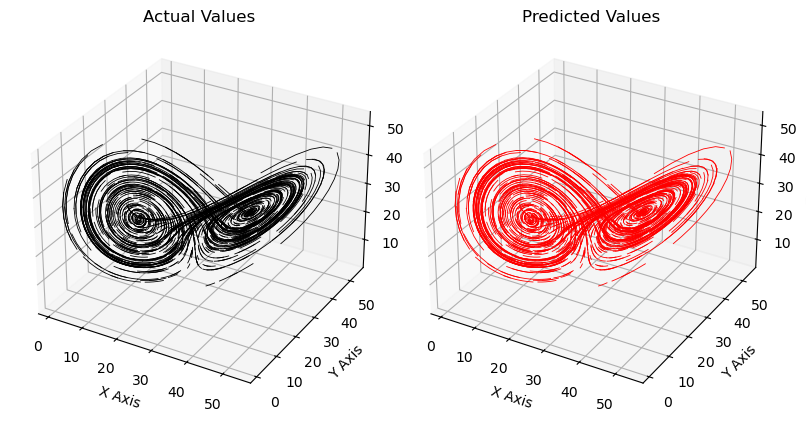

In [35]:
# Going for a different approach to show result
# Figure 1: Actual Values
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(121, projection='3d')  # 121 means 1 row, 2 columns, plot 1

# Plot the data points
for i in range(len(x_actual_values)):
    ax1.plot(x_actual_values[i], y_actual_values[i], z_actual_values[i], linestyle='-', color='black', lw = 0.6)

# Set labels and title
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')
ax1.set_title('Actual Values')

# Figure 2: Predicted Values
ax2 = fig.add_subplot(122, projection='3d')  # 122 means 1 row, 2 columns, plot 2

# Plot the data points
for i in range(len(x_predicted_values)):
    ax2.plot(x_predicted_values[i], y_predicted_values[i], z_predicted_values[i], linestyle='-', color='red', lw = 0.6)

# Set labels and title
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Z Axis')
ax2.set_title('Predicted Values')

# Show both plots side by side
plt.tight_layout()
plt.show()

In [36]:
## Makes me want to do a huge time prediction
## Extreme Multi-Step Ahead Chaotic Time Series Prediction
# Input: 200
# Output: 100

dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

x_dimension = xyzs[:, 0]

x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
x_dimension.index = range(len(x_dimension))

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()

In [37]:
input_size = 200         
output_size = 100        
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

x_rmse, x_mae, x_mape = [], [], []
metrics = ['rmse', 'mae', 'mape']
variables = ['x']
metric_dict = {f"{var}_{metric}_steps": [[] for _ in range(output_size)] for var in variables for metric in metrics}

In [38]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    x_mse = mean_squared_error(y_test, y_pred)
    x_rmse.append(np.sqrt(mse))

    for step in range(output_size):
        x_mse_step = mean_squared_error(y_pred[step], y_test[step])
        metric_dict['x_rmse_steps'][step].append(np.sqrt(x_mse_step))

    # Inverse Transform
    x_predicted_values = scaler.inverse_transform(y_pred)
    x_actual_values = scaler.inverse_transform(y_test)

    x_mae.append(mean_absolute_error(x_actual_values, x_predicted_values))
    x_mape.append(mean_absolute_percentage_error(x_actual_values, x_predicted_values))

    actual_values_steps = list(zip(*x_actual_values))
    predicted_values_steps = list(zip(*x_predicted_values))

    for step in range(output_size):
        metric_dict['x_mae_steps'][step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        metric_dict['x_mape_steps'][step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    
    # print(f"Exp {i+1} on x test set: RMSE: {x_rmse[i]:.7f}, MAE: {x_mae[i]:.5f}, MAPE: {x_mape[i]:.7f}")
    seed += 1

print(f"Univariate Linear Regression x dimension: Avg RMSE: {np.mean(x_rmse):.6f}, Avg MAE: {np.mean(x_mae):.4f}, Avg MAPE: {np.mean(x_mape)*100:.4f}%")

for step in range(output_size):
    if step == 0 or (step + 1) % 10 == 0:
        print(f"At time step {step + 1}, Avg RMSE: {np.mean(metric_dict['x_rmse_steps'][step]):.4f}, Avg MAE: {np.mean(metric_dict['x_mae_steps'][step]):.4f}, Avg MAPE: {np.mean(metric_dict['x_mape_steps'][step])*100:.3f}%")


Univariate Linear Regression x dimension: Avg RMSE: 0.095963, Avg MAE: 4.7602, Avg MAPE: 147.8413%
At time step 1, Avg RMSE: 0.1311, Avg MAE: 0.0000, Avg MAPE: 0.000%
At time step 10, Avg RMSE: 0.1568, Avg MAE: 0.0215, Avg MAPE: 0.650%
At time step 20, Avg RMSE: 0.1330, Avg MAE: 0.9810, Avg MAPE: 31.569%
At time step 30, Avg RMSE: 0.1552, Avg MAE: 3.5431, Avg MAPE: 110.006%
At time step 40, Avg RMSE: 0.1399, Avg MAE: 5.5078, Avg MAPE: 304.916%
At time step 50, Avg RMSE: 0.1451, Avg MAE: 6.3750, Avg MAPE: 255.945%
At time step 60, Avg RMSE: 0.1646, Avg MAE: 6.7086, Avg MAPE: 201.976%
At time step 70, Avg RMSE: 0.1538, Avg MAE: 6.8197, Avg MAPE: 156.521%
At time step 80, Avg RMSE: 0.1481, Avg MAE: 6.8930, Avg MAPE: 153.348%
At time step 90, Avg RMSE: 0.1547, Avg MAE: 6.9357, Avg MAPE: 151.035%
At time step 100, Avg RMSE: 0.1642, Avg MAE: 6.9367, Avg MAPE: 156.316%


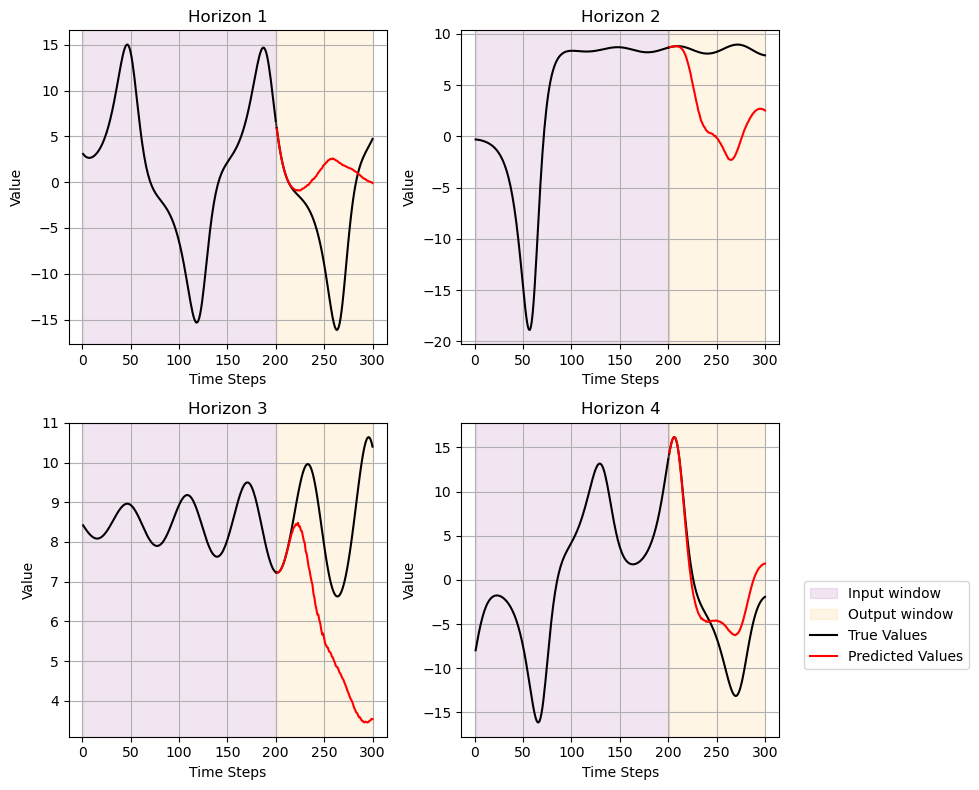

In [39]:
X_test_inv = scaler.inverse_transform(X_test)
# Time steps for the entire sequence (input + output)
full_time_steps = list(range(1, input_size + output_size + 1))

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i in range(4):    
    ax = axs[i]
    ax.axvspan(1, input_size + 0.5, color='purple', alpha=0.1, label = 'Input window')
    ax.axvspan(input_size + 0.5, input_size + output_size, color='orange', alpha=0.1, label = 'Output window')
    ax.plot(full_time_steps[:input_size], X_test_inv[i], linestyle='-', color='black', label='True Values')
    ax.plot(full_time_steps[input_size:], x_actual_values[i], linestyle='-', color='black')
    ax.plot(full_time_steps[input_size:], x_predicted_values[i], linestyle='-', color='red', label='Predicted Values')
    ax.plot([full_time_steps[input_size - 1], full_time_steps[input_size]], [X_test_inv[i][-1], x_actual_values[i][0]],
            linestyle='--', color='black', alpha=0.7)
    
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.6, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [40]:
# to be honest, it's not too bad considering we are predicting 100 values into the future
# but of course, the code did not capture the whole shape so there is always room to improve

In [41]:
## Quantile Version
dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# break it down to 3 univariate time series
x_dimension = xyzs[:, 0]
y_dimension = xyzs[:, 1]
z_dimension = xyzs[:, 2]

x_dimension = x_dimension.flatten()
x_dimension = pd.Series(x_dimension, name='Value')
y_dimension = y_dimension.flatten()
y_dimension = pd.Series(y_dimension, name='Value')
z_dimension = z_dimension.flatten()
z_dimension = pd.Series(z_dimension, name='Value')

x_dimension.index = range(len(x_dimension))
y_dimension.index = range(len(y_dimension))
z_dimension.index = range(len(z_dimension))

scaler = MinMaxScaler(feature_range=(0, 1))
x_reshaped = np.array(x_dimension).reshape(-1, 1)
y_reshaped = np.array(y_dimension).reshape(-1, 1)
z_reshaped = np.array(z_dimension).reshape(-1, 1)
x_scaled = scaler.fit_transform(x_reshaped).flatten()
y_scaled = scaler.fit_transform(y_reshaped).flatten()
z_scaled = scaler.fit_transform(z_reshaped).flatten()

In [42]:
# Usage
input_size = 10        # 10 steps input
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 2    # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [43]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(x_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0012, MAE: 0.02, MAPE: 0.0013
Exp 2 on test set: RMSE: 0.0012, MAE: 0.02, MAPE: 0.0012
--------------------------------------------
Univariate Quantile Regression Avg RMSE: 0.0012, Avg MAE: 0.02, Avg MAPE: 0.124%
At time step 1, Avg RMSE: 0.0002, Avg MAE: 0.00, Avg MAPE: 0.008%
At time step 2, Avg RMSE: 0.0003, Avg MAE: 0.00, Avg MAPE: 0.022%
At time step 3, Avg RMSE: 0.0022, Avg MAE: 0.00, Avg MAPE: 0.028%
At time step 4, Avg RMSE: 0.0002, Avg MAE: 0.01, Avg MAPE: 0.087%
At time step 5, Avg RMSE: 0.0015, Avg MAE: 0.03, Avg MAPE: 0.204%
At time step 6, Avg RMSE: 0.0008, Avg MAE: 0.06, Avg MAPE: 0.395%
--------------------------------------------
At Quantile 0.05, it has Avg RMSE: 0.0014
At Quantile 0.25, it has Avg RMSE: 0.0011
At Quantile 0.5, it has Avg RMSE: 0.0012
At Quantile 0.75, it has Avg RMSE: 0.0011
At Quantile 0.95, it has Avg RMSE: 0.0012


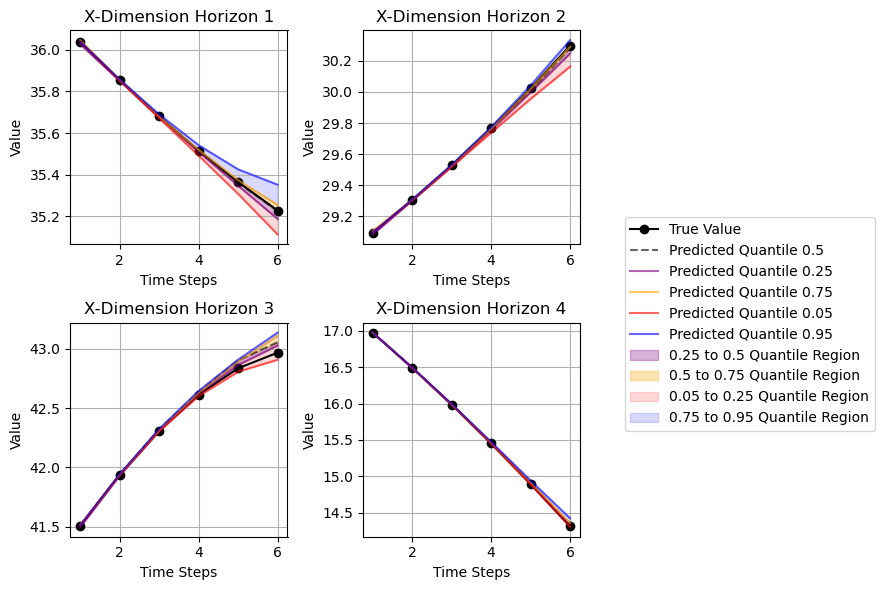

In [44]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i in range(4):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'X-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [45]:
# can do the same thing with Y and Z dimensions but will be of a similar result...
# just repetitive at this point, but below are Y & Z dimensions results

# Usage
input_size = 10        # 10 steps input
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 2    # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [46]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(y_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0024, MAE: 0.03, MAPE: 0.0021
Exp 2 on test set: RMSE: 0.0022, MAE: 0.03, MAPE: 0.0019
--------------------------------------------
Univariate Quantile Regression Avg RMSE: 0.0023, Avg MAE: 0.03, Avg MAPE: 0.198%
At time step 1, Avg RMSE: 0.0003, Avg MAE: 0.02, Avg MAPE: 0.105%
At time step 2, Avg RMSE: 0.0005, Avg MAE: 0.00, Avg MAPE: 0.013%
At time step 3, Avg RMSE: 0.0018, Avg MAE: 0.01, Avg MAPE: 0.052%
At time step 4, Avg RMSE: 0.0002, Avg MAE: 0.02, Avg MAPE: 0.119%
At time step 5, Avg RMSE: 0.0062, Avg MAE: 0.04, Avg MAPE: 0.267%
At time step 6, Avg RMSE: 0.0023, Avg MAE: 0.10, Avg MAPE: 0.633%
--------------------------------------------
At Quantile 0.05, it has Avg RMSE: 0.0025
At Quantile 0.25, it has Avg RMSE: 0.0020
At Quantile 0.5, it has Avg RMSE: 0.0023
At Quantile 0.75, it has Avg RMSE: 0.0020
At Quantile 0.95, it has Avg RMSE: 0.0027


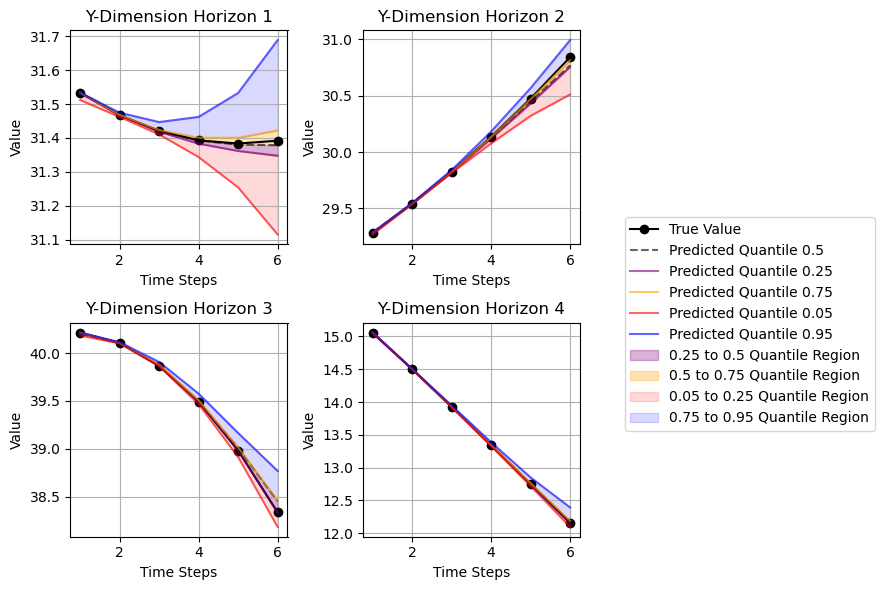

In [47]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i in range(4):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Y-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [48]:
# Z-Dimension
# Usage
input_size = 10        # 10 steps input
output_size = 6        # 6 steps output
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 2    # change to lower value for less intensive runs

# Initialize lists for metrics
rmse = []
quantile_rmse = {q: [] for q in quantiles}
steps_rmse = [[] for _ in range(output_size)]
mae = []
steps_mae = [[] for _ in range(output_size)]
mape = []
steps_mape = [[] for _ in range(output_size)]

In [49]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(z_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        steps_rmse[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        steps_mae[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        steps_mape[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print("--------------------------------------------")
print(f"Univariate Quantile Regression Avg RMSE: {np.mean(rmse):.4f}, Avg MAE: {np.mean(mae):.2f}, Avg MAPE: {np.mean(mape)*100:.3f}%")
for step in range(output_size):
    print(f"At time step {step + 1}, Avg RMSE: {np.mean(steps_rmse[step]):.4f}, Avg MAE: {np.mean(steps_mae[step]):.2f}, Avg MAPE: {np.mean(steps_mape[step])*100:.3f}%")
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f}")

Exp 1 on test set: RMSE: 0.0023, MAE: 0.03, MAPE: 0.0010
Exp 2 on test set: RMSE: 0.0027, MAE: 0.04, MAPE: 0.0015
--------------------------------------------
Univariate Quantile Regression Avg RMSE: 0.0025, Avg MAE: 0.03, Avg MAPE: 0.128%
At time step 1, Avg RMSE: 0.0002, Avg MAE: 0.00, Avg MAPE: 0.012%
At time step 2, Avg RMSE: 0.0003, Avg MAE: 0.01, Avg MAPE: 0.035%
At time step 3, Avg RMSE: 0.0037, Avg MAE: 0.02, Avg MAPE: 0.052%
At time step 4, Avg RMSE: 0.0008, Avg MAE: 0.02, Avg MAPE: 0.075%
At time step 5, Avg RMSE: 0.0086, Avg MAE: 0.05, Avg MAPE: 0.183%
At time step 6, Avg RMSE: 0.0007, Avg MAE: 0.11, Avg MAPE: 0.409%
--------------------------------------------
At Quantile 0.05, it has Avg RMSE: 0.0028
At Quantile 0.25, it has Avg RMSE: 0.0021
At Quantile 0.5, it has Avg RMSE: 0.0025
At Quantile 0.75, it has Avg RMSE: 0.0022
At Quantile 0.95, it has Avg RMSE: 0.0036


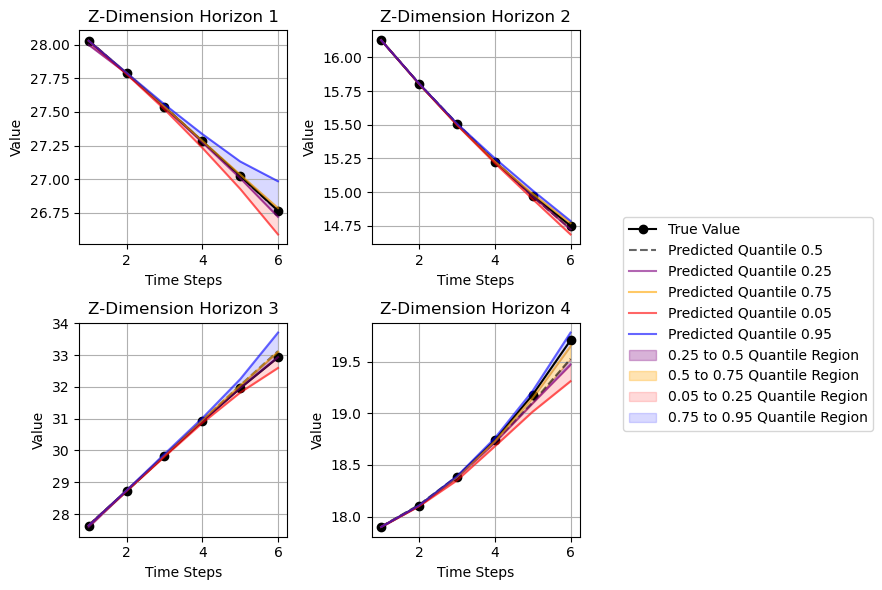

In [50]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i in range(4):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Z-Dimension Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [51]:
# Overall, not sure how necessary Lorenz dataset is to our project
# Just 3x extra work from Mackey-Glass imo